In [15]:
# Install necessary libraries
!pip install tensorflow matplotlib scikit-learn opencv-python


In [2]:
# Mount Google Drive to access dataset uplaoded on drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Import the zipfile module to extract compressed dataset
import zipfile

zip_path = '/content/drive/MyDrive/dataset/chest-xray-pneumonia.zip'
extract_path = '/content/chest-xray-pneumonia' #destination path

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/chest-xray-pneumonia')


In [5]:
import os

base_dir = '/content/chest-xray-pneumonia'
print("Folders in base directory:", os.listdir(base_dir))


Folders in base directory: ['chest_xray']


In [6]:
base_dir = '/content/chest-xray-pneumonia/chest_xray'


In [7]:
import os
# Loop through each dataset split: training, validation, and testing
for folder in ['train', 'val', 'test']:
    path = os.path.join(base_dir, folder)
    print(f"\n{folder.upper()}:")
     # For each category in the split, print the number of images
    for category in ['NORMAL', 'PNEUMONIA']:
        category_path = os.path.join(path, category)
        print(f"{category}: {len(os.listdir(category_path))} images")



TRAIN:
NORMAL: 1341 images
PNEUMONIA: 3875 images

VAL:
NORMAL: 8 images
PNEUMONIA: 8 images

TEST:
NORMAL: 234 images
PNEUMONIA: 390 images


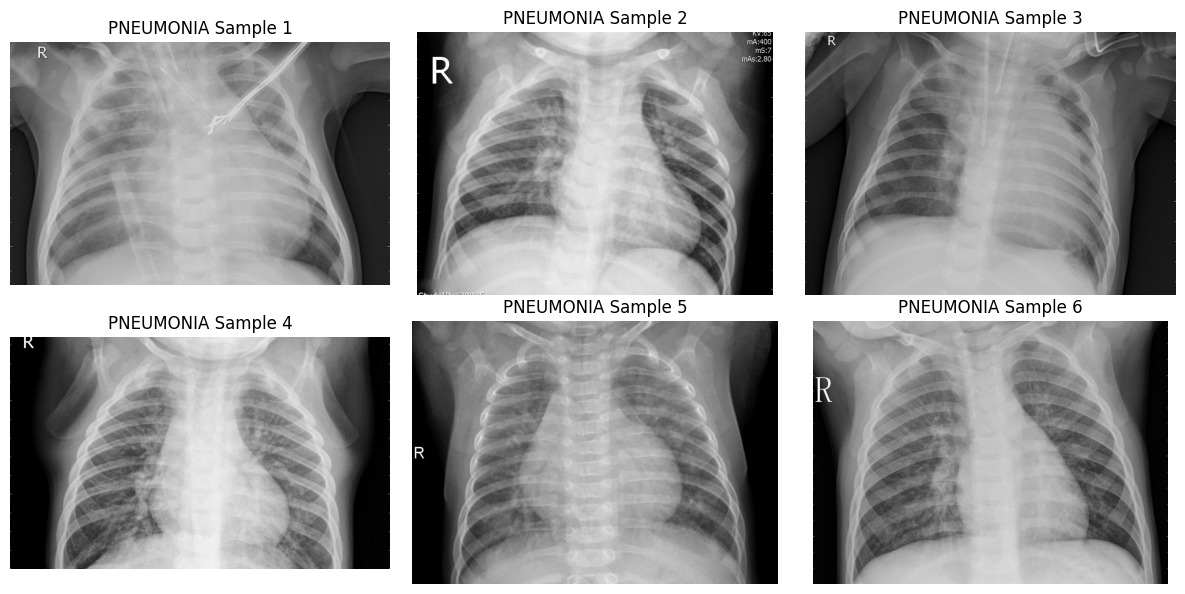

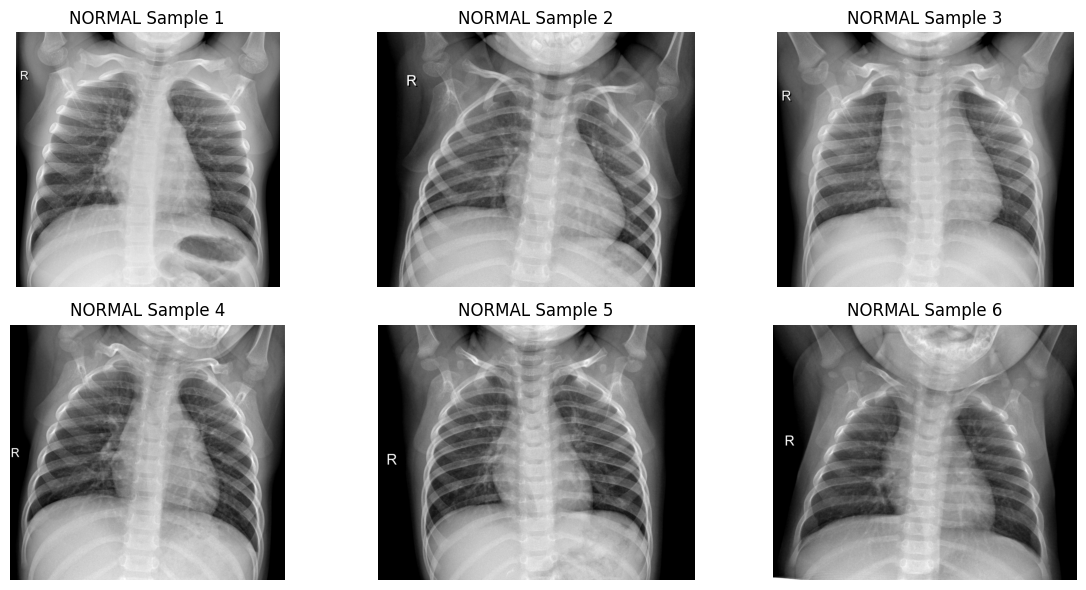

In [8]:
# Visualize example images and get an intuitive understanding of the dataset
import matplotlib.pyplot as plt
import cv2

def show_sample_images(category='PNEUMONIA', set_type='train'):
    path = os.path.join(base_dir, set_type, category)
    sample_files = os.listdir(path)[:6]
    plt.figure(figsize=(12, 6))
    for i, file in enumerate(sample_files):
        img = cv2.imread(os.path.join(path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"{category} Sample {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images('PNEUMONIA')
show_sample_images('NORMAL')


In [9]:
# Preprocesses the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# target image size for resizing all input images
img_size = (224, 224)

train_gen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=32,
    class_mode='binary'
)

val_data = val_test_gen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size,
    batch_size=32,
    class_mode='binary'
)

test_data = val_test_gen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Print summary
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the CNN model on the training data
history_cnn = cnn_model.fit(
    train_data,
    epochs=25,
    validation_data=val_data
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 612ms/step - accuracy: 0.7565 - loss: 0.5626 - val_accuracy: 0.8125 - val_loss: 0.3965
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 601ms/step - accuracy: 0.8963 - loss: 0.2597 - val_accuracy: 0.8125 - val_loss: 0.4210
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 601ms/step - accuracy: 0.9031 - loss: 0.2342 - val_accuracy: 0.6875 - val_loss: 0.7661
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 601ms/step - accuracy: 0.9066 - loss: 0.2361 - val_accuracy: 0.6250 - val_loss: 1.1818
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 591ms/step - accuracy: 0.9229 - loss: 0.1942 - val_accuracy: 0.6250 - val_loss: 1.0863
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 597ms/step - accuracy: 0.9314 - loss: 0.1732 - val_accuracy: 0.6875 - val_loss: 0.7621
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 596ms/step - accuracy: 0.9221 - loss: 0.1916 - val_accuracy: 0.6250 - val_loss: 0.8240
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 593ms/step - accuracy: 0.9412 - loss

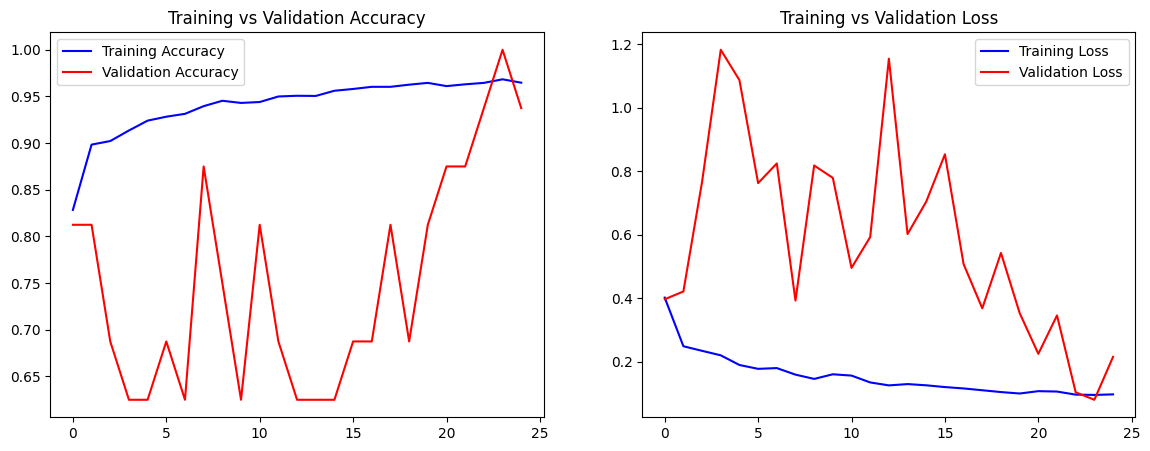

In [12]:
import matplotlib.pyplot as plt

# plot training and validation accuracy/loss curves
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.show()

plot_training(history_cnn)


In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_tl = Model(inputs=base_model.input, outputs=output)

# Compile
model_tl.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Summary
model_tl.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
# train the model
history_tl = model_tl.fit(
    train_data,
    epochs=25,
    validation_data=val_data
)


Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 614ms/step - accuracy: 0.6273 - loss: 0.6963 - val_accuracy: 0.5000 - val_loss: 0.6860
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 588ms/step - accuracy: 0.7496 - loss: 0.5068 - val_accuracy: 0.5000 - val_loss: 0.6145
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 589ms/step - accuracy: 0.8021 - loss: 0.4204 - val_accuracy: 0.5000 - val_loss: 0.5976
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 591ms/step - accuracy: 0.8381 - loss: 0.3567 - val_accuracy: 0.5625 - val_loss: 0.5523
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 584ms/step - accuracy: 0.8578 - loss: 0.3331 - val_accuracy: 0.6250 - val_loss: 0.5321
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 582ms/step - accuracy: 0.8789 - loss: 0.2861 - val_accuracy: 0.6875 - val_loss: 0.5004
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 580ms/step - accuracy: 0.8773 - loss: 0.2824 - val_accuracy: 0.6875 - val_loss: 0.4946
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 580ms/step - accuracy: 0.8825 - loss: 

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- Evaluate CNN model ---
print("Evaluating CNN model:")

y_true = test_data.classes  # True class labels from the test generator

y_pred_cnn = cnn_model.predict(test_data)

y_pred_cnn = (y_pred_cnn > 0.5).astype("int32").flatten()

print(confusion_matrix(y_true, y_pred_cnn))
print(classification_report(y_true, y_pred_cnn, target_names=["NORMAL", "PNEUMONIA"]))


# --- Evaluate MobileNetV2 transfer learning model ---
print("Evaluating MobileNetV2 model:")

y_pred_tl = model_tl.predict(test_data)

y_pred_tl = (y_pred_tl > 0.5).astype("int32").flatten()

print(confusion_matrix(y_true, y_pred_tl))
print(classification_report(y_true, y_pred_tl, target_names=["NORMAL", "PNEUMONIA"]))


Evaluating CNN model:
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step
[[126 108]
 [  3 387]]
              precision    recall  f1-score   support

      NORMAL       0.98      0.54      0.69       234
   PNEUMONIA       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.77      0.78       624
weighted avg       0.85      0.82      0.81       624

Evaluating MobileNetV2 model:
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step
[[159  75]
 [  6 384]]
              precision    recall  f1-score   support

      NORMAL       0.96      0.68      0.80       234
   PNEUMONIA       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Generates Grad-CAM heatmap for the predicted class or specified class
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    # Create a sub-model that maps input to the activations of the last conv layer and output
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Record gradients of the predicted class with respect to conv layer outputs
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Get predicted class index
        class_channel = predictions[:, pred_index]

    # Compute gradients of the class output w.r.t. conv layer output
    grads = tape.gradient(class_channel, conv_outputs)
    # Average gradients over width and height
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the convolutional features by the gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Loads image, generates Grad-CAM, and overlays it on original image
def display_gradcam(image_path, model, last_conv_layer_name='conv2d_2'):
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array / 255.0, axis=0)  # Normalize to [0,1]

    # Generate Grad-CAM heatmap
    heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)

    # Resize and color-map the heatmap
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on the original image
    superimposed = heatmap_colored * 0.4 + img_array[0] * 255
    superimposed = np.uint8(superimposed)

    # Display the final Grad-CAM image
    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed.astype("uint8"))
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.show()


In [18]:
import os

test_pneumonia_dir = "/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA"
files = os.listdir(test_pneumonia_dir)
print(files[:5])  # print first 5 files


['person126_bacteria_599.jpeg', 'person1655_virus_2861.jpeg', 'person101_bacteria_486.jpeg', 'person1657_virus_2864.jpeg', 'person101_bacteria_485.jpeg']


In [19]:
for layer in cnn_model.layers:
    print(layer.name)


conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense
dropout
dense_1


In [20]:
# dummy input to initialize model
_ = cnn_model.predict(np.zeros((1, 224, 224, 3)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


In [21]:
from tensorflow.keras import layers, models, Input

# Input layer for 224x224 RGB images
input_layer = Input(shape=(224, 224, 3))

# 1st Convolution + MaxPooling
x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)

# 2nd Convolution + MaxPooling
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# 3rd Convolution + MaxPooling — also named for Grad-CAM layer targeting
x = layers.Conv2D(128, (3, 3), activation='relu', name='conv2d_2')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten feature maps into 1D vector
x = layers.Flatten()(x)

# Fully connected dense layer with dropout to reduce overfitting
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output layer — 1 neuron with sigmoid for binary classification
output = layers.Dense(1, activation='sigmoid')(x)

# Build and compile the model
cnn_model = models.Model(inputs=input_layer, outputs=output)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_168']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


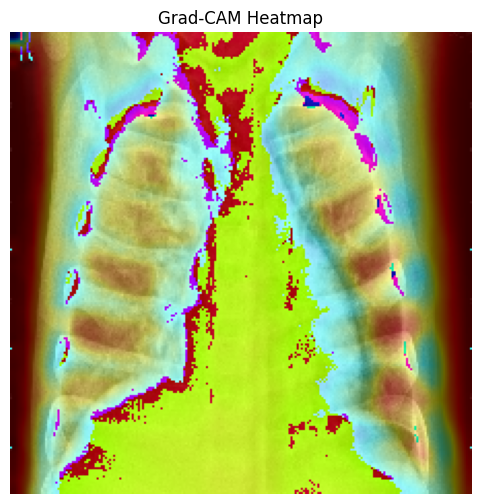

In [22]:
sample_path = '/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person22_virus_54.jpeg'
display_gradcam(sample_path, cnn_model, last_conv_layer_name='conv2d_2')


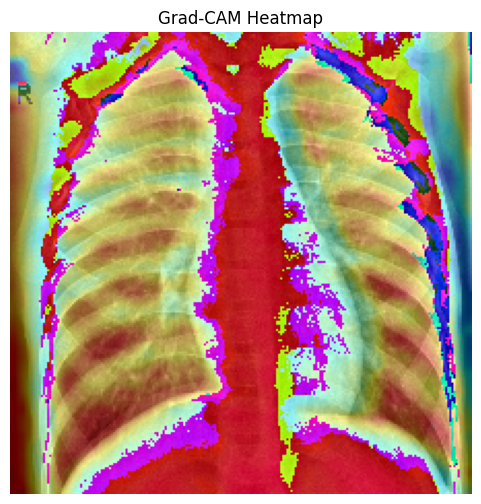

In [27]:
sample_path = '/content/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0277-0001.jpeg'
display_gradcam(sample_path, cnn_model, last_conv_layer_name='conv2d_2')


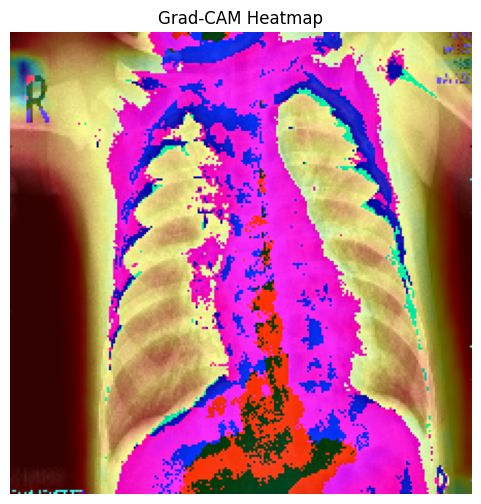

In [28]:
sample_path = '/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person47_virus_99.jpeg'
display_gradcam(sample_path, cnn_model, last_conv_layer_name='conv2d_2')